In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df = pd.read_csv('positives_till_may_15.csv')
df

,content
0,NaN
1,Coronavirus Disease 2019 (COVID-19) and Chloro...
2,NaN
3,Chloroquine and hydroxychloroquine have displa...
4,NaN
...,...
262,NaN
263,Conclusion\t \tTop
264,NaN
265,NaN


In [4]:
df['content'] = df['content'].fillna('').apply(str)
df

,content
0,
1,Coronavirus Disease 2019 (COVID-19) and Chloro...
2,
3,Chloroquine and hydroxychloroquine have displa...
4,
...,...
262,
263,Conclusion\t \tTop
264,
265,


In [5]:
# Convert to list
data = df.content.values.tolist()


# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


['']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[[]]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[]


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])



[[]]


In [11]:
id2word[0]

'chloroquine'

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

In [29]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.919200202626952

Coherence Score:  0.5822370787037365


In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.277009 -0.095301       1        1  19.612745
0     -0.238044 -0.150141       2        1  17.820621
6     -0.204463  0.275273       3        1  10.183919
10     0.001741  0.149156       4        1   7.973228
7      0.028669  0.056293       5        1   5.744960
1      0.039920 -0.002175       6        1   4.499462
16     0.008121 -0.003711       7        1   4.206922
9      0.047540 -0.031778       8        1   4.001722
17     0.048170 -0.035548       9        1   3.035993
11     0.044739 -0.015203      10        1   2.834965
21     0.021465 -0.010620      11        1   2.826464
24     0.014104  0.010246      12        1   2.783070
23     0.052659  0.013251      13        1   2.548814
22     0.000837 -0.044041      14        1   2.533066
2      0.041476 -0.022685      15        1   2.529377
12     0.030767 -0.022547      16        1   1.765495
5      0.027148 -0.024917      17        1   1.674413
20     0.054534 -0.011977      18        1   1.259784
19     0.056289 -0.008582      19        1   0.955293
4      0.036080 -0.004530      20        1   0.279642
15     0.034186 -0.004231      21        1   0.206390
14     0.032767 -0.004058      22        1   0.182785
8      0.032767 -0.004058      23        1   0.180360
13     0.032767 -0.004058      24        1   0.180273
3      0.032768 -0.004058      25        1   0.180234, topic_info=               Term       Freq      Total Category  logprob  loglift
0       chloroquine  56.000000  56.000000  Default  30.0000  30.0000
62             drug  72.000000  72.000000  Default  29.0000  29.0000
30            virus  16.000000  16.000000  Default  28.0000  28.0000
19          patient  48.000000  48.000000  Default  27.0000  27.0000
301             day  27.000000  27.000000  Default  26.0000  26.0000
..              ...        ...        ...      ...      ...      ...
242        pandemic   0.004143   9.148099  Topic25  -6.8742  -1.3811
138  interpretation   0.004143   2.220525  Topic25  -6.8742   0.0347
132         include   0.004143  16.895769  Topic25  -6.8742  -1.9946
236    manufacturer   0.004143   3.276055  Topic25  -6.8742  -0.3542
126            give   0.004143  11.329909  Topic25  -6.8742  -1.5950

[1142 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         5  0.863801     ability
386       1  0.757497        able
411      12  0.845901     absence
332       6  0.769490  absolutely
43        1  0.770967  accelerate
...     ...       ...         ...
100       1  0.871167       would
100       7  0.145194       would
180       2  0.841734       write
463       4  0.915770        year
181       1  0.757820         yet

[583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 1, 7, 11, 8, 2, 17, 10, 18, 12, 22, 25, 24, 23, 3, 13, 6, 21, 20, 5, 16, 15, 9, 14, 4])

In [63]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

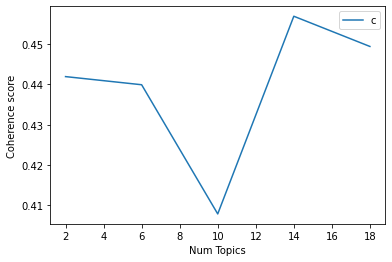

In [69]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=4)
# Show graph
import matplotlib.pyplot as plt
limit=22; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [70]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))



Num Topics = 2  has Coherence Value of 0.4419
Num Topics = 6  has Coherence Value of 0.4399
Num Topics = 10  has Coherence Value of 0.4079
Num Topics = 14  has Coherence Value of 0.4569
Num Topics = 18  has Coherence Value of 0.4494
